# Introduction
- This notebook presents Python code for the algorithm described in https://www.researchgate.net/publication/320864673_A_simple_algorithm_to_find_all_real_roots_of_a_polynomial. Please cite this paper if you use this code or part of it.
- The code finds all real roots of a polynomial, using mpmath por arbitrary precision arithmetics.
- A companion notebook presents Python code for the same algorithm, using standard floating point arithmetics.
- You may also read the *Fundamentals* notebook in this repository.
- This notebook contains code and tests using some notorious polynomials

# Code
Notes:
- We use mpmath to get arbitrary precision numbers.
- Sympy polynomials and some associated functions are used for the sake of clarity.

## Solver

In [41]:
import mpmath
from mpmath import mp, mpf
from sympy import init_session
    # We use sympy just to facilitate the construction of examples and to pretty print polynomials
init_session()

IPython console for SymPy 1.9 (Python 3.8.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.9/



In [42]:
def mp_roots(p, tolerance, bracketing):
    """
    Returns a list of all real roots of (sympy) polynomial p.
    
    Parameters
    ----------
    p : sympy polynomial
    tolerance : mpmath mpf number
        A number x is considered a root of p if abs(p(x)) < tolerance
    bracketing : function
        A bracketing method for root-finding function such as bisection, newton, brent or hibrid
    ----------
    
    """
    
    global verbose_main_loop
    
    todo = [] # to do stack
    
    while degree(p) > 1: # push derivatives
        todo.append(p)
        p = diff(p)
        
    # p is a first degree polynomial
    cfs = Poly(p).all_coeffs()
    roots = [-mpf(cfs[1]) / mpf(cfs[0])]
    
    if verbose_main_loop:
        print(f'\nSolving {p}')
    
    pdiff = p
    func_pdiff = lambdify(x, pdiff, 'mpmath')
    
    while len(todo) > 0: # pop derivatives
        derivative_roots = roots
        p = todo.pop()
        if verbose_main_loop:
            print(f'\nSolving {p}')
        p_as_function = lambdify(x, p, 'mpmath')
        roots = real_roots_from_derivative_roots(p, p_as_function, func_pdiff, 
                                                 derivative_roots, tolerance, bracketing)
        func_pdiff = p_as_function
    
    return roots

In [43]:
def real_roots_from_derivative_roots(p, p_as_function, func_pdiff, derivative_roots, tolerance, bracketing):
    """
    This function finds the real roots of polynomial p, using the roots of the derivative of p
    
    Parameters
    ----------
    p : sympy polynomial
    p_as_function : function
        Calculates p(x)
    func_pdiff : function
        Calculates p'(x), where p' is the derivative of p. Used by bracketings like newton or hibrid
    derivative_roots : list
        List of all roots of p'. Must be in ascending order
    tolerance : mpmath mpf number
        A number x is considered a root of p if abs(p(x)) < tolerance
    bracketing : function
        A bracketing root-finding function such as bisection    
    ----------
    """
    
    
    n_derivative_roots = len(derivative_roots)
    
    roots = []
    
    #print(f'rrfdr: derivative_roots = {derivative_roots}, {type(derivative_roots)}----\n')
    if n_derivative_roots == 0:
        # I took 0, but any point should work
        left_extremity = mpf(0)
        right_extremity = mpf(0)
    else:
        left_extremity = derivative_roots[0]
        right_extremity = derivative_roots[-1]
    #print(f'left_extremity = {left_extremity}, {type(left_extremity)}')
    #print(f'right_extremity = {right_extremity}, {type(right_extremity)}')
    
    right_limit_sign = sign(LC(p)) # LC: Leading Coefficient
    
    if degree(p) % 2 == 0:
        left_limit_sign = sign(LC(p))
    else:
        left_limit_sign = -sign(LC(p)) 
    
    roots = roots + external_root(p, p_as_function, func_pdiff, left_extremity, left_limit_sign, mpf(-1), tolerance, bracketing)
    #print(f'After left external root, roots = {roots}')
    
    for i in range(n_derivative_roots - 1): 

        roots = roots + internal_root(p, p_as_function, func_pdiff, derivative_roots[i], derivative_roots[i+1], tolerance, bracketing)
        #print(f'After internal root, roots = {roots}')
        
    roots = roots + external_root(p, p_as_function, func_pdiff, right_extremity, right_limit_sign, mpf(1), tolerance, bracketing)
    #print(f'After right external root, roots = {roots}')
    
    return roots

In [44]:
def external_root(p, p_as_function, func_pdiff, extremity, limit_sign, initial_step, tolerance, bracketing):
    """
    Look for a root in intervals where one of its limits is -infinity or infinity
    
    Parameters
    ----------
    p : sympy polynomial
    p_as_function : function
        Calculates p(x)
    func_pdiff : function
        Calculates p'(x), where p' is the derivative of p. Used by bracketings like newton or hibrid
    extremity : number
        Interval is either (-infinity, extremity] or (extremity, infinity), depending on initial_step
    limit_sign : number sign
        Sign of polynomial at -infinity or at infinity, depending on initial_step
    initial_step :
        number
        initial_step must be a nonzero value; normally, initial_step == mpf(1). 
        If initial_step < 0, the function will start by looking for a bracketing
        interval testing values from extremity towards -infinity.
        If initial_step > 0, the function will start by looking for a bracketing
        interval testing values from extremity towards infinity.
    tolerance : mpmath mpf number
        A number x is considered a root of p if abs(p(x)) < tolerance
    bracketing : function
        A bracketing root-finding function such as bisection 
    ----------
    """
    global verbose_bracketing
    
    #print(f'external_root: extremity = {extremity}')
    value_at_extremity = p_as_function(extremity)
    
    if abs(value_at_extremity) <= tolerance:
        if initial_step < 0:
            root_found = [extremity]
        else:
            root_found = []
    else:
    
        sign_at_extremity = sign(value_at_extremity)

        if limit_sign == sign_at_extremity:
            root_found = []
        else:

            if initial_step > 0:
                a = extremity
                b = point_with_sign_inversion(p_as_function, extremity, sign_at_extremity, initial_step)
            else:
                a = point_with_sign_inversion(p_as_function, extremity, sign_at_extremity, initial_step)
                b = extremity
            #print(f'left_external_root: calling findroot for {p}')
            #print(f'a = {a}, left_extremity = {left_extremity}')
            #root_found = [findroot(p_as_function, [a, b], bracketing='anderson', tol=tolerance,
            #                      maxsteps=MAXSTEPS)]
        #    root_found = [bisection(p, p_as_function, a, b, tolerance)]
            if verbose_bracketing:
                print(f'external_root: calling bracketing for p = {p}')
            root_found = [bracketing(a, b, tolerance, p_as_function, func_pdiff)]
        
    #print(f'{p}: {root_found} added by external_root')
    return root_found

In [45]:
def point_with_sign_inversion(p_as_function, extremity, sign_at_extremity, initial_step):
    """
    Finds a bracketing interval starting from an interval with one of its limits equal to infinity or -infinity
    
    Parameters
    ----------
    p_as_function : function
        Calculates p(x)
    extremity : number
        Interval is either (-infinity, extremity] or (extremity, infinity), 
        and extremity is either the smallest or the greatest root of derivative, depending on initial_step.  
    sign_at_extremity : number sign
        Sign of p(extremity)
    initial_step :
        number
        initial_step must be a nonzero value; normally, initial_step equals mpf(1) or mpf(-1). 
        If initial_step < 0, the function will start by looking for a bracketing
        interval testing values from extremity towards -infinity.
        If initial_step > 0, the function will start by looking for a bracketing
        interval testing values from extremity towards infinity.    
    ----------
    """

    #print(f'Looking for {p} sign inversion from x = {extremity} with initial step = {initial_step}')
    step = initial_step
    x = extremity + step
    p_x = p_as_function(x)
    sign_at_x = sign(p_x)
    
    while sign_at_x == sign_at_extremity:
        step = 2*step # Double step length
        x = x + step
        p_x = p_as_function(x)
        #print(f'x = {x}, p_x = {p_x}, step = {step}')
        sign_at_x = sign(p_x)
        
    return x

In [46]:
def internal_root(p, p_as_function, func_pdiff, a, b, tolerance, bracketing):
    """
    Looks for a root in intervals where both limits are finite numbers
    
    Parameters
    ----------
    p : sympy polynomial
    p_as_function : function
        Calculates p(x)
    func_pdiff : function
        Calculates p'(x), where p' is the derivative of p. Used by bracketings like newton or hibrid 
    a : number
        Left limit of interval
    b : number
        Right limit of interval
    tolerance : mpmath mpf number
        A number x is considered a root of p if abs(p(x)) < tolerance
    bracketing : function
        A bracketing root-finding function such as bisection         
    ----------
    """
    global verbose_bracketing
    #print(f'Approximating root of {p}, {a} <= root <= {b}')
    p_a = p_as_function(a)
    #print(f'internal_root: p_a = {p_a}')
    if abs(p_a) <= tolerance:
        root_found = []
    else:
        p_b = p_as_function(b)
        if abs(p_b) < tolerance:
            root_found = [b]
        else:
            sign_at_a = sign(p_a)
            sign_at_b = sign(p_b)
            if sign_at_a == sign_at_b:
                root_found = []
            else:
                if verbose_bracketing:
                    print(f'internal_root: calling bracketing for p = {p}')
                root_found = [bracketing(a, b, tolerance, p_as_function, func_pdiff)]
    #print(f'{p}: {root_found} added by internal_root')
    return root_found

In [47]:
def bisection(a, b, tolerance, p_as_function, func_pdiff):

    global verbose_bracketing
    if verbose_bracketing:
        print('bisection: starting')

    p_a = p_as_function(a)
    p_b = p_as_function(b)
    m = (a + b) / 2
    p_m = p_as_function(m)
    progress = True
    
    iter = 0
    while abs(p_m) > tolerance and progress:
        iter += 1
        old_a, old_b = a, b
        if p_a * p_m <= 0:
            b = m
            p_b = p_m
        else:
            if p_b * p_m <= 0:
                a = m
                p_a = p_m
        m = (a + b) / 2
        p_m = p_as_function(m)
        if old_a == a and old_b == b:
            progress = False
            raise ValueError(f'bissection: no progress after {iter} iterations, with \na = {a} \nb = {b}')
    if verbose_bracketing:
        print(f'bisection: finishing after {iter} iterations')
    return m

In [48]:
# Testing bisection
global verbose_bracketing
verbose_bracketing = True
mp.dps = 50

p = ((x-1)*(x-mpmath.sqrt(2))*(x-3)).expand()
print(f'p = {p}')
pdiff = p.diff()

p_as_function = lambdify(x, p, 'mpmath')
func_pdiff = lambdify(x, pdiff, 'mpmath')
r = bisection(mpf(1.1), mpf(2.0), mpf('1.0e-30'), p_as_function, func_pdiff)
print(r, r*r)

p = x**3 - 5.4142135623730950488016887242096980785696718753769*x**2 + 8.6568542494923801952067548968387923142786875015078*x - 4.2426406871192851464050661726290942357090156261308
bisection: starting
bisection: finishing after 97 iterations
1.4142135623730950488016887242105194110828816440373 2.0000000000000000000000000000023230791587984681689


In [49]:
def mpmath_bracketing ( a, b, tol, f, func_pdiff):
    global verbose_bracketing
    if verbose_bracketing:
        print(f'mpmath_bracketing: calling mpmath.findroot')
    return findroot(f, (a + b)/mpf(2), bracketing='anewton', tol = tol, maxsteps = 10000)

In [50]:
def hibrid( a, b, tolerance, f, fdiff):
    """
    bracketing that mixes Newton-Raphson and Bisection methods.
    Adapted from https://doi.org/10.12988/ams.2017.710302   
    """
    
    global verbose_bracketing
    if verbose_bracketing:
        print('hibrid: starting')
        
    iter = 0
    f_a = f(a)
    f_b = f(b)
    if f_a * f_b > 0:
        raise ValueError(f'f(a) and f(b) must have opposite signs')
    n_bisec = 0
    n_newton = 0
    m = (a + b)/2
    f_m = f(m)
    
    while abs(f_m) > tolerance:
        old_a, old_b = a, b
        # print(f'a = {a}\nb = {b}\nm={m}')
        iter += 1
        f_m = f(m)
        fdiff_m = fdiff(m)
        next_x_newton = m - f_m / fdiff_m
        
        if (a < next_x_newton < b): # and (iter % 10 != 0):
            # Take newton guess
            m = next_x_newton
            n_newton += 1
        else:
            # Take bisection guess
            m = (a + b)/2
            n_bisec += 1           
        f_m = f(m)
        if f_a * f_m <= 0:
            b = m
            f_b = f_m
        if f_b * f_m <= 0:
            a = m
            f_a = f_m
        if a == old_a and b == old_b:
            raise ValueError(f'hibrid: no progress after {iter} iterations, '
                             f'with \na = {a}\nb = {b}\nm={m} \nb - a = {b - a}'
                             f'\nold_a = {old_a}\nold_b = {old_b}')
            break
    if verbose_bracketing:
        print(f'hibrid: finishing after {iter} iterations,'
              f' n_newton = {n_newton}, n_bisec = {n_bisec}')
        print(f'root found: {m}')
        print(f'abs(f_m) = {abs(f_m)}')
    return m
        
    

In [51]:
# Testing hibrid
global verbose_bracketing
verbose_bracketing = True
mp.dps = 800
p = ((x-1) * (x-2)**3 * (x-3)).expand()
func_p = lambdify(x, p, 'mpmath')
pdiff = p.diff()
func_pdiff = lambdify(x, pdiff, 'mpmath')

hibrid(mpf(1.1), mpf(2.5), mpf('1.0e-400'), func_p, func_pdiff)

hibrid: starting
hibrid: finishing after 754 iterations, n_newton = 754, n_bisec = 0
root found: 1.9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999670846202267260327688953076598305821051946334314907387112831806606846709292209445683779038220939872779048522608194639990470129216316055014958996759133774986055555109050150975758956979711853546257918946317720004739693256076676179858297713253555535711937811650228859289403387241692575302855561777746546510799775608283177814496999903122548595380218728641219330661638082169727932310663536450808421716762866895938262561102136493911354048721255072149213831913788466424450348699231651378265413411452484337770065610844066576176191482748192424677193358720318595073509150897618460160115293561508584313711459921568777660872974119649769214509772821403901432805416826517401802317
abs(f_m) = 3.5661254011050258711356265950876017301403502004908494153696553090359320359527643419966187

mpf('1.9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999670846202267260327688953076598305821051946334314907387112831806606846709292209445683779038220939872779048522608194639990470129216316055014958996759133774986055555109050150975758956979711853546257918946317720004739693256076676179858297713253555535711937811650228859289403387241692575302855561777746546510799775608283177814496999903122548595380218728641219330661638082169727932310663536450808421716762866895938262561102136493911354048721255072149213831913788466424450348699231651378265413411452484337770065610844066576176191482748192424677193358720318595073509150897618460160115293561508584313711459921568777660872974119649769214509772821403901432805416826517401802316524')

In [52]:
def newton(a, b, tolerance, f, fdiff, maxiter=2000):
    #convergence not guaranteed
    global verbose_bracketing
    if verbose_bracketing:
        print('newton: starting...')
    iter = 0
    x_newton = (a + b)/2
    while abs(f(x_newton)) > tolerance:
        iter += 1
        if iter >= maxiter:
            raise ValueError(f'newton: no convergence after {iter} iterations')
            break
        x_newton = x_newton - f(x_newton)/fdiff(x_newton)
    if verbose_bracketing:
        print(f'newton: ending after {iter} iterations')
    return x_newton

In [53]:
# Testing newton
global verbose_bracketing
mp.dps = 400
p = ((x-1) * (x-2)**10 * (x-3)).expand()
func_p = lambdify(x, p, 'mpmath')
pdiff = p.diff()
func_pdiff = lambdify(x, pdiff, 'mpmath')
verbose_bracketing = True
newton(mpf(1.1), mpf(2.5), mpf(1.0e-300), func_p, func_pdiff)

newton: starting...
newton: ending after 641 iterations


mpf('1.999999999999999999999999999999070178837574413081405488838695075936682761847908997431829948302292545630439443648508400074310605348403823460870628612376570645520764285846367419122821432737759539914682231871420409786025237040626176847714168548309674189741702200054805557388104477194061875392956617865055185104410403356379906823698950307142042509546778330287406081000433097313091590453620171433018616108354')

## Checking roots

In [54]:
def sign_at_minus_inf(p):
    #print(f'sign_at_minus_inf: p = {p}')
    if degree(p) % 2 == 0:
        s = sign(LC(p, x))
    else:
        s = sign(-LC(p, x))
    #print(f's = {s}')
    return s
    
def sign_at_plus_inf(p):
    #print(f'sign_at_plus_inf: p = {p}')
    s = sign(LC(p, x))
    #print(f's = {s}')
    return s

In [55]:
def Sturm(p):
    """
    Returns total number of distinct real roots of p, based on Sturm's theorem
    https://en.wikipedia.org/wiki/Sturm%27s_theorem
    """
    minus_inf_sign_inversions = 0
    plus_inf_sign_inversions = 0
    
    last_p = p.diff()

    if sign_at_minus_inf(p) != sign_at_minus_inf(last_p):
        minus_inf_sign_inversions += 1
    if sign_at_plus_inf(p) != sign_at_plus_inf(last_p):
        plus_inf_sign_inversions += 1
        
    last_sign_at_minus_inf = sign_at_minus_inf(last_p)
    last_sign_at_plus_inf = sign_at_plus_inf(last_p)

    while degree(last_p) > 0:
        next_p = -rem(p, last_p)
        #print(f'p = {p}, last_p = {last_p}, next_p = {next_p}')
        if sign_at_minus_inf(next_p) != last_sign_at_minus_inf:
            minus_inf_sign_inversions += 1
        if sign_at_plus_inf(next_p) != last_sign_at_plus_inf:
            plus_inf_sign_inversions += 1
        p = last_p
        last_p = next_p
        last_sign_at_minus_inf = sign_at_minus_inf(last_p)
        last_sign_at_plus_inf = sign_at_plus_inf(last_p)        
        
    return minus_inf_sign_inversions - plus_inf_sign_inversions

In [56]:
def check_roots(p, roots, tolerance):
    
    # Are all elements of roots distinct and in ascending order?
    for i in range(len(roots) - 1):
        if roots[i] >= roots[i + 1]:
            raise ValueError(f'roots[{i}] is >= roots[{i + 1}]')
    print(f'\ncheck_roots: all roots are distinct and in order')
    # For all r in roots, abs(p(r)) <= tolerance?
    p_as_function = lambdify(x, p, 'mpmath')
    for r in roots:
        abs_p_r = abs(p_as_function(r))
        if abs_p_r > tolerance:
            raise ValueError(f'abs(p({r})) = {abs_p_r} > {tolerance}')
    print(f'check_roots: all roots are roots within tolerance')
    # Number of elements of roots equals Sturm(p)?
    n_roots_Sturm = Sturm(p)
    if len(roots) != n_roots_Sturm:
        raise ValueError(f"We have {len(roots)} real roots; "
                         f"{n_roots_Sturm} real roots were expected by Sturm's theorem.")
    print(f"check_roots: number of real roots, {n_roots_Sturm},"
          " as expected by Sturm's theorem")

## Plotting polynomials and printing roots

In [62]:
%matplotlib inline

def plot_p(p, xlim):
    """
    Plots a polynomial
    """
    v = np.linspace(xlim[0], xlim[1], 200)
    #print(f'v = {v}')
    func_p = lambdify(x, p, 'numpy')
    
    ax = plt.gca()
    y_p = func_p(v)
    plt.gcf().text(0.02, -0.1, '$' + latex(p) + '$', fontsize=11)
    

    ax.plot(v, y_p, 'b')

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    
    plt.show()

In [59]:
def print_roots(p, roots):
    print(f'\nReal roots of p(x) =\n{p}')
    for i, r in enumerate(roots):
        print(f'Root[{i}] = \n{r}')

# Tests
For the construction of tests, sympy is a fundamental tool.

## Polynomials with known roots

In [60]:
def poly_from_roots(poly_roots, constant=Rational(1)):
    """
    Constructs a polynomial from a list of is roots. 
    If a complex number is included in list, its conjugate will be included too.
    """
    x = Symbol('x')
    W = constant
    for r in poly_roots:
        if isinstance(r, complex):
            a = Rational(r.real)
            b = Rational(r.imag)
            W = W * (a**2 - 2*a*x + b**2 + x**2)
        else:
            W = W * (x - Rational(r))
    return W.expand()

### Polynomial with real and complex roots

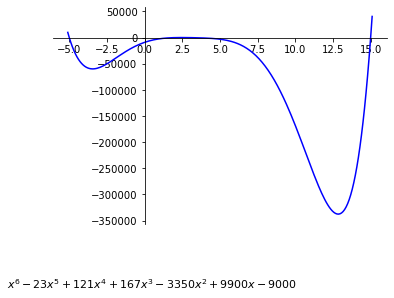

In [63]:
p = poly_from_roots([3, 2, -5, 4 + 2j, 15])
plot_p(p, [-5.1, 15.1])

In [64]:
global verbose_bracketing, verbose_main_loop
mp.dps = 40 # number of digits
tolerance = mp.mpf('1.0e-15')
bracketing = hibrid
verbose_bracketing = False
verbose_main_loop = False
roots = mp_roots(p, tolerance, bracketing)

# try to uncomment one or more of these lines
# roots[2] = roots[0]
# roots[2] = 2.4
# roots = roots[:-1]

print_roots(p, roots)


Real roots of p(x) =
x**6 - 23*x**5 + 121*x**4 + 167*x**3 - 3350*x**2 + 9900*x - 9000
Root[0] = 
-5.000000000000000000000000501595455822748
Root[1] = 
1.999999999999999999999999999999995688763
Root[2] = 
3.000000000000000000000000000000023369982
Root[3] = 
15.00000000000000000000000000000000021189


In [65]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 4, as expected by Sturm's theorem


### A polynomial with roots with multiplicity

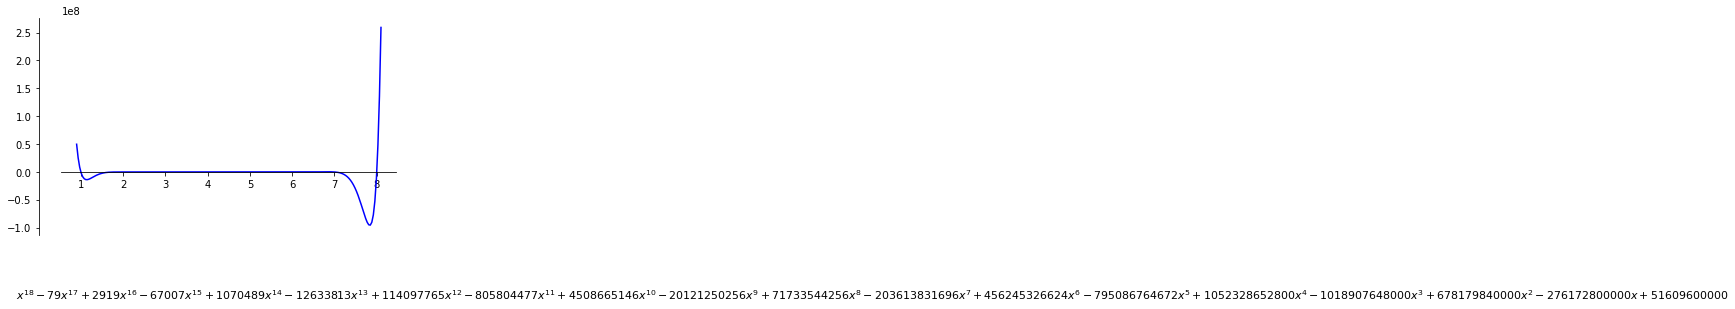

In [69]:
p = poly_from_roots([1] + [2]*3 + [4, 5]*5 + [6]*2 + [7, 8])
plot_p(p, [0.9, 8.1])

In [66]:
N_DIGITS = 40
mp.dps = N_DIGITS
tolerance = mp.mpf('1.0e-15')
bracketing = newton
global verbose_bracketing, verbose_main_loop
verbose_bracketing = False
verbose_main_loop = False
roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)


Real roots of p(x) =
x**18 - 79*x**17 + 2919*x**16 - 67007*x**15 + 1070489*x**14 - 12633813*x**13 + 114097765*x**12 - 805804477*x**11 + 4508665146*x**10 - 20121250256*x**9 + 71733544256*x**8 - 203613831696*x**7 + 456245326624*x**6 - 795086764672*x**5 + 1052328652800*x**4 - 1018907648000*x**3 + 678179840000*x**2 - 276172800000*x + 51609600000
Root[0] = 
0.9999999999999999999999999999996766890358
Root[1] = 
1.999999999999999999999999999998512898563
Root[2] = 
4.000000000000000000000000000001539657522
Root[3] = 
5.000000000000000000000000000069256759081
Root[4] = 
6.000000000000000000000000056398167613971
Root[5] = 
7.000000000000000000000002749774652321272
Root[6] = 
8.000000000000000000000000000000000878629

check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 7, as expected by Sturm's theorem


In [33]:
# Just to show how numpy.roots and mpmath.polyroots both fail in this case. 

coefs = Poly(p).all_coeffs()

print(f'\nnumpy version: {np.version.version}')
# numpy(version: 1.21.2).roots find spurious imaginary parts
print(np.roots(coefs))

print(f'\nmpmath version: {mpmath.__version__}')
# mpmath(version: 1.2.1).polyroots does not converge
print(mpmath.polyroots(coefs, maxsteps=5000))


numpy version: 1.21.2
[8.00000235+0.j         6.99994307+0.j         6.00781171+0.04459148j
 6.00781171-0.04459148j 5.37230549+0.27596291j 5.37230549-0.27596291j
 4.95068068+0.46307242j 4.95068068-0.46307242j 4.41988124+0.37777607j
 4.41988124-0.37777607j 3.97434411+0.3095069j  3.97434411-0.3095069j
 3.77500415+0.12105877j 3.77500415-0.12105877j 2.00083618+0.00146186j
 2.00083618-0.00146186j 1.99832748+0.j         1.        +0.j        ]

mpmath version: 1.2.1


NoConvergence: Didn't converge in maxsteps=5000 steps.

### Wilkinson polynomials

In [34]:
def Wilkinson(n):
    return poly_from_roots(list(range(1,n+1)))

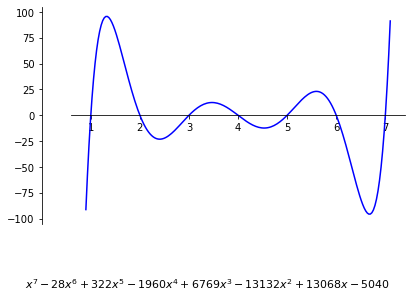

In [35]:
# Check Wilkinson constructor
p = Wilkinson(7)
%matplotlib inline
plot_p(p, (0.90, 7.10))

In [39]:
global verbose_main_loop, verbose_bracketing
mp.dps = 300
tolerance = mpf('1.0e-15')
bracketing = hibrid
verbose_bracketing = False
verbose_main_loop = False
p = Wilkinson(50)

#%prun -s cumulative mp_roots(p, tolerance, bracketing)

# Uncomment line above and comment lines bellow if you want time measures

roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)


Real roots of p(x) =
x**50 - 1275*x**49 + 791350*x**48 - 318622500*x**47 + 93570498490*x**46 - 21366198225750*x**45 + 3949131291964600*x**44 - 607317906105487500*x**43 + 79274383168492884295*x**42 - 8916311500907225617125*x**41 + 874274440470458637491350*x**40 - 75430949131153796097540000*x**39 + 5769557497517595816762422380*x**38 - 393625378247020213038955570500*x**37 + 24074634262098477202456261501600*x**36 - 1325513314288519699308436238355000*x**35 + 65926306456751344865378122278650335*x**34 - 2970483623265905855449410614694043125*x**33 + 121537997067927371629961551678685914850*x**32 - 4524229387507572623070958774667674282500*x**31 + 153457012425237702675940309806097247177498*x**30 - 4748411888781425210165280179331840887560950*x**29 + 134153032410638239369309397211318138160939400*x**28 - 3462458978207366446890224680162408296258877500*x**27 + 81661954970720573655661780303655361431161958585*x**26 - 1759975170237895559117007667844300114185022044875*x**25 + 3465207876504419845209509058

In [40]:
check_roots(p, roots, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 50, as expected by Sturm's theorem


## Mignotte polynomials

In [ ]:
def Mignotte(n, tau):
    x = Symbol('x')
    return (x**n - ((2**(tau//2) - 1)*x - 1)**2).expand()

In [ ]:
p = Mignotte(11, 14)

plot_p(p, (-2, 3.0))

In [ ]:
## bracketing = newton
verbose_bracketing = False
verbose_main_loop = False
mp.dps = 100
n = 11
tau = 14
p = Mignotte(n, tau)
print(f'p = {p}')

tolerance = mpf('1.0e-50')

#%prun -s cumulative mp_roots(p, tolerance, bracketing)

# Uncomment line above and comment lines bellow if you want time measures

roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)

In [ ]:
bracketing = hibrid
verbose_bracketing = False
verbose_main_loop = False

n = 513
tau = 14
p = Mignotte(n, tau)

mp.dps = 1750 # number of digits in mpmath
# try mp.dps = 1000
tolerance = mpf('1.0e-1500')
# try tolerance = mpf('1.0e-150')

#%prun -s cumulative mp_roots(p, tolerance, bracketing)

# Uncomment line above and comment lines bellow if you want time measures

roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)

## Nested Mignotte polynomials

In [70]:
def nested_Mignotte(n, tau):
    x = symbols('x')
    p = 1
    for i in range(1, 5):
        p = p * (x**(n//4) - ((2**(tau//8) - 1)*x**2 - 1)**(2*i))
    return p.expand()

In [71]:
nested_Mignotte(4, 8)

In [72]:
bracketing = hibrid
verbose_bracketing = False
verbose_main_loop = False
mp.dps = 2000
n = 64
tau = 14
p = nested_Mignotte(n, tau)

tolerance = mpf('1.0e-500')
#%prun -s cumulative mp_roots(p, tolerance, bracketing)

roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)


Real roots of p(x) =
8*x**62 - 28*x**60 + 48*x**58 + 6*x**56 - 296*x**54 + 1018*x**52 - 2204*x**50 + 3431*x**48 - 3640*x**46 + 1195*x**44 + 5782*x**42 - 18474*x**40 + 35648*x**38 - 52353*x**36 + 61082*x**34 - 55275*x**32 + 31984*x**30 + 8261*x**28 - 61790*x**26 + 119594*x**24 - 166000*x**22 + 184326*x**20 - 167900*x**18 + 125966*x**16 - 77520*x**14 + 38760*x**12 - 15504*x**10 + 4845*x**8 - 1140*x**6 + 190*x**4 - 20*x**2 + 1
Root[0] = 
-0.85117093406701547892839654212806696054076915457816011364738004495864302623100603057655869910635266481456271777496481830096917400958841550093958508615931762807777416957545507336831085124331792814184666909177032697971852312671025185791258915789482319598333576397841200621262256847808433426178373048812162930857822426663197504356820788973154624143625167028898947452667724729258290396550762763956403464983430892162150240583979040397448408276547564245189334059002792394766563642610271436035169285686602656602634896678589928393782007728357052313137614019961384009

check_roots: number of real roots, 8, as expected by Sturm's theorem


## Chebyshev polynomials of first kind

In [73]:
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

@memoize
def Chebyshev(n):
    x = symbols('x')
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return (2*x*Chebyshev(n-1) - Chebyshev(n-2)).expand()

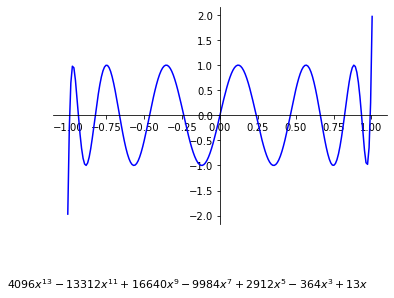

In [74]:
p = Chebyshev(13)
plot_p(p, [-1.005, 1.005])

In [75]:
n = 65
mp.dps = 800
bracketing = hibrid
p = Chebyshev(n)
tolerance = mpf('1.0e-50')
verbose_main_loop = False
verbose_bracketing = False
roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)


Real roots of p(x) =
18446744073709551616*x**65 - 299759591197780213760*x**63 + 2323136831782796656640*x**61 - 11428334414415370649600*x**59 + 40069426604640777011200*x**57 - 106584674768344466849792*x**55 + 223556839026824199536640*x**53 - 379385867215472594780160*x**51 + 530391426205841620992000*x**49 - 618789997240148557824000*x**47 + 608101806378727810007040*x**45 - 506751505315606508339200*x**43 + 359745762028296129740800*x**41 - 218188997679883747328000*x**39 + 113219921064981692416000*x**37 - 50269644952851871432704*x**35 + 19075534915144683356160*x**33 - 6171496590193868144640*x**31 + 1696067325319236812800*x**29 - 393937834141653401600*x**27 + 76817877657622413312*x**25 - 12470434684678963200*x**23 + 1667558126439628800*x**21 - 181256318091264000*x**19 + 15749405687808000*x**17 - 1070959586770944*x**15 + 55449091031040*x**13 - 2107713986560*x**11 + 55948006400*x**9 - 964620800*x**7 + 9646208*x**5 - 45760*x**3 + 65*x
Root[0] = 
-0.9997080140801929642838083404567874893379113994

check_roots: number of real roots, 65, as expected by Sturm's theorem


## Random coefficients

In [76]:
def randomPoly(n, tau):
    from random import choices
    c = np.arange(-(2**tau), 2**tau + 1)
    coefs = choices(c, k=n+1)
    p = 1
    for i in range(n+1):
        p = p + coefs[i]*x**i
    return p

In [77]:
randomPoly(4, 3)

In [78]:
n = 64
tau = 20
mp.dps = 800
bracketing = hibrid
p = randomPoly(n, tau)
tolerance = mpf('1.0e-50')
verbose_main_loop = False
verbose_bracketing = False
roots = mp_roots(p, tolerance, bracketing)
print_roots(p, roots)
check_roots(p, roots, tolerance)


Real roots of p(x) =
-862460*x**64 - 703791*x**63 + 316470*x**62 + 167845*x**61 + 459366*x**60 + 573280*x**59 + 619567*x**58 + 754480*x**57 + 638105*x**56 - 814238*x**55 - 435672*x**54 - 1015323*x**53 + 429700*x**52 - 768527*x**51 + 91940*x**50 - 52335*x**49 + 884947*x**48 + 480799*x**47 - 461310*x**46 + 1008235*x**45 - 129110*x**44 + 788830*x**43 - 369229*x**42 + 136497*x**41 - 167455*x**40 - 618246*x**39 - 251729*x**38 + 964815*x**37 + 43208*x**36 - 575621*x**35 - 995705*x**34 - 236766*x**33 + 512650*x**32 + 684090*x**31 - 925281*x**30 + 899578*x**29 + 646987*x**28 + 789188*x**27 - 978490*x**26 + 296396*x**25 - 566231*x**24 + 1029259*x**23 + 827262*x**22 + 368605*x**21 - 261450*x**20 - 293435*x**19 - 802520*x**18 + 842188*x**17 - 272852*x**16 - 694499*x**15 + 158957*x**14 - 317441*x**13 + 645314*x**12 - 1023362*x**11 - 288174*x**10 - 161202*x**9 + 980559*x**8 - 104537*x**7 - 257282*x**6 + 667416*x**5 + 154421*x**4 - 866916*x**3 + 556151*x**2 - 998940*x + 23218
Root[0] = 
-1.31197623

<div class="cite2c-biblio"></div>